Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v4 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


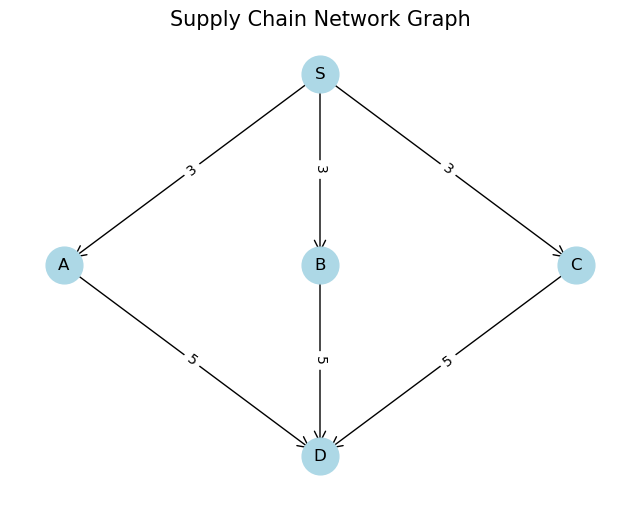

In [4]:
env.render_network()

In [5]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [6]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

        env.render()

    # print(env.order_history)

Episode Length: 1
Stock Level: [20.2 28.  19.4]
Planned Demand: [ 8.1  0.  11.8]
Actual Demand: [ 9.8  0.  12.6]
Action: [37.3  2.5 22.6]
Order: [0 0 0]
Reward: -730.020491334313

Episode Length: 2
Stock Level: [ 8.9 28.  19.4]
Planned Demand: [9.5 0.  0. ]
Actual Demand: [11.3  0.   0. ]
Action: [23.4 30.6 20.5]
Order: [0 0 0]
Reward: -1460.8782470545448

Episode Length: 3
Stock Level: [ 8.9 28.  19.4]
Planned Demand: [15.3  0.   0. ]
Actual Demand: [16.3  0.   0. ]
Action: [40.3 37.  34.9]
Order: [0 0 0]
Reward: -3229.372137876095

Episode Length: 4
Stock Level: [20.1 30.5 42. ]
Planned Demand: [10.1  0.   0. ]
Actual Demand: [9.8 0.  0. ]
Action: [38.4 49.9  3.7]
Order: [37.3  2.5 22.6]
Reward: -4013.9371308182767

Episode Length: 5
Stock Level: [33.6 61.1 62.5]
Planned Demand: [11.3  0.   0. ]
Actual Demand: [9.9 0.  0. ]
Action: [32.1 16.9 31.4]
Order: [23.4 30.6 20.5]
Reward: -4851.556786048939

Episode Length: 6
Stock Level: [73.9 98.1 97.4]
Planned Demand: [0. 0. 0.]
Actual Dem

**Train Model**


In [7]:
log_path = os.path.join('Training', 'Logs')
# model_path = os.path.join('Training', 'Models', 'PPO')
model_path = os.path.join('Training', 'Models', 'A2C')

In [8]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

def make_env():
    # Create a new environment here
    env = SS_Mngmt_Env(network_config=network_config, EP_LENGTH=EP_LENGTH, render_mode="human")
    return env

num_envs = 8

# dummy_env = DummyVecEnv(make_env, n_envs=num_envs)
vec_env = make_vec_env(make_env, n_envs=num_envs)

# model = PPO("MlpPolicy", 
#             dummy_env,
#             learning_rate = 0.0007,
#             gamma = 0.99,
#             verbose=1,
#             tensorboard_log=log_path)

model = A2C("MlpPolicy",
            vec_env,
            learning_rate = 0.0005,
            gamma = 0.9,
            verbose=1,
            tensorboard_log=log_path)

Using cpu device


In [9]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/A2C_9
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -5.09e+05 |
| time/                 |           |
|    fps                | 9338      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 4000      |
| train/                |           |
|    entropy_loss       | -4.26     |
|    explained_variance | -1.43e-06 |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | -1.35e+05 |
|    std                | 1         |
|    value_loss         | 1.14e+09  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -4.97e+05 |
| time/                 |           |
|    fps                | 9320      |
|    iterations         | 200       |
|    time_elapsed  

In [10]:
model.save(model_path)
model.load(model_path)

evaluate_policy(model, vec_env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [15.4 16.9 32. ]
Planned Demand: [11.  10.8  0. ]
Actual Demand: [14.6 11.1  0. ]
Action: [27.7 18.6 13.6]
Order: [0 0 0]
Reward: -724.153250169137

Episode Length: 1
Stock Level: [30.  18.9 28.8]
Planned Demand: [ 0.  10.3  2. ]
Actual Demand: [0.  9.1 3.2]
Action: [28.5 18.7 10.6]
Order: [0 0 0]
Reward: -735.4726979292044

Episode Length: 1
Stock Level: [30.  18.1 30. ]
Planned Demand: [ 0.  11.3  4.7]
Actual Demand: [0.  9.9 2. ]
Action: [24.7 19.8 10.8]
Order: [0 0 0]
Reward: -733.3393935290417

Episode Length: 1
Stock Level: [16.7 21.7 26.7]
Planned Demand: [13.7  8.9  6.9]
Actual Demand: [13.3  6.3  5.3]
Action: [29.  22.7 21.2]
Order: [0 0 0]
Reward: -737.9699600602421

Episode Length: 1
Stock Level: [30. 21. 32.]
Planned Demand: [0.  8.3 0. ]
Actual Demand: [0. 7. 0.]
Action: [28.9 14.8 14.7]
Order: [0 0 0]
Reward: -741.4703787286091

Episode Length: 1
Stock Level: [30. 28. 22.]
Planned Demand: [ 0.   0.  12.4]
Actual Demand: [ 0.  0. 10.]
Action:

([-514502.833736], [30])

In [11]:
df = pd.read_csv('./Data/2024-10-14_20_last_environment_data.csv')

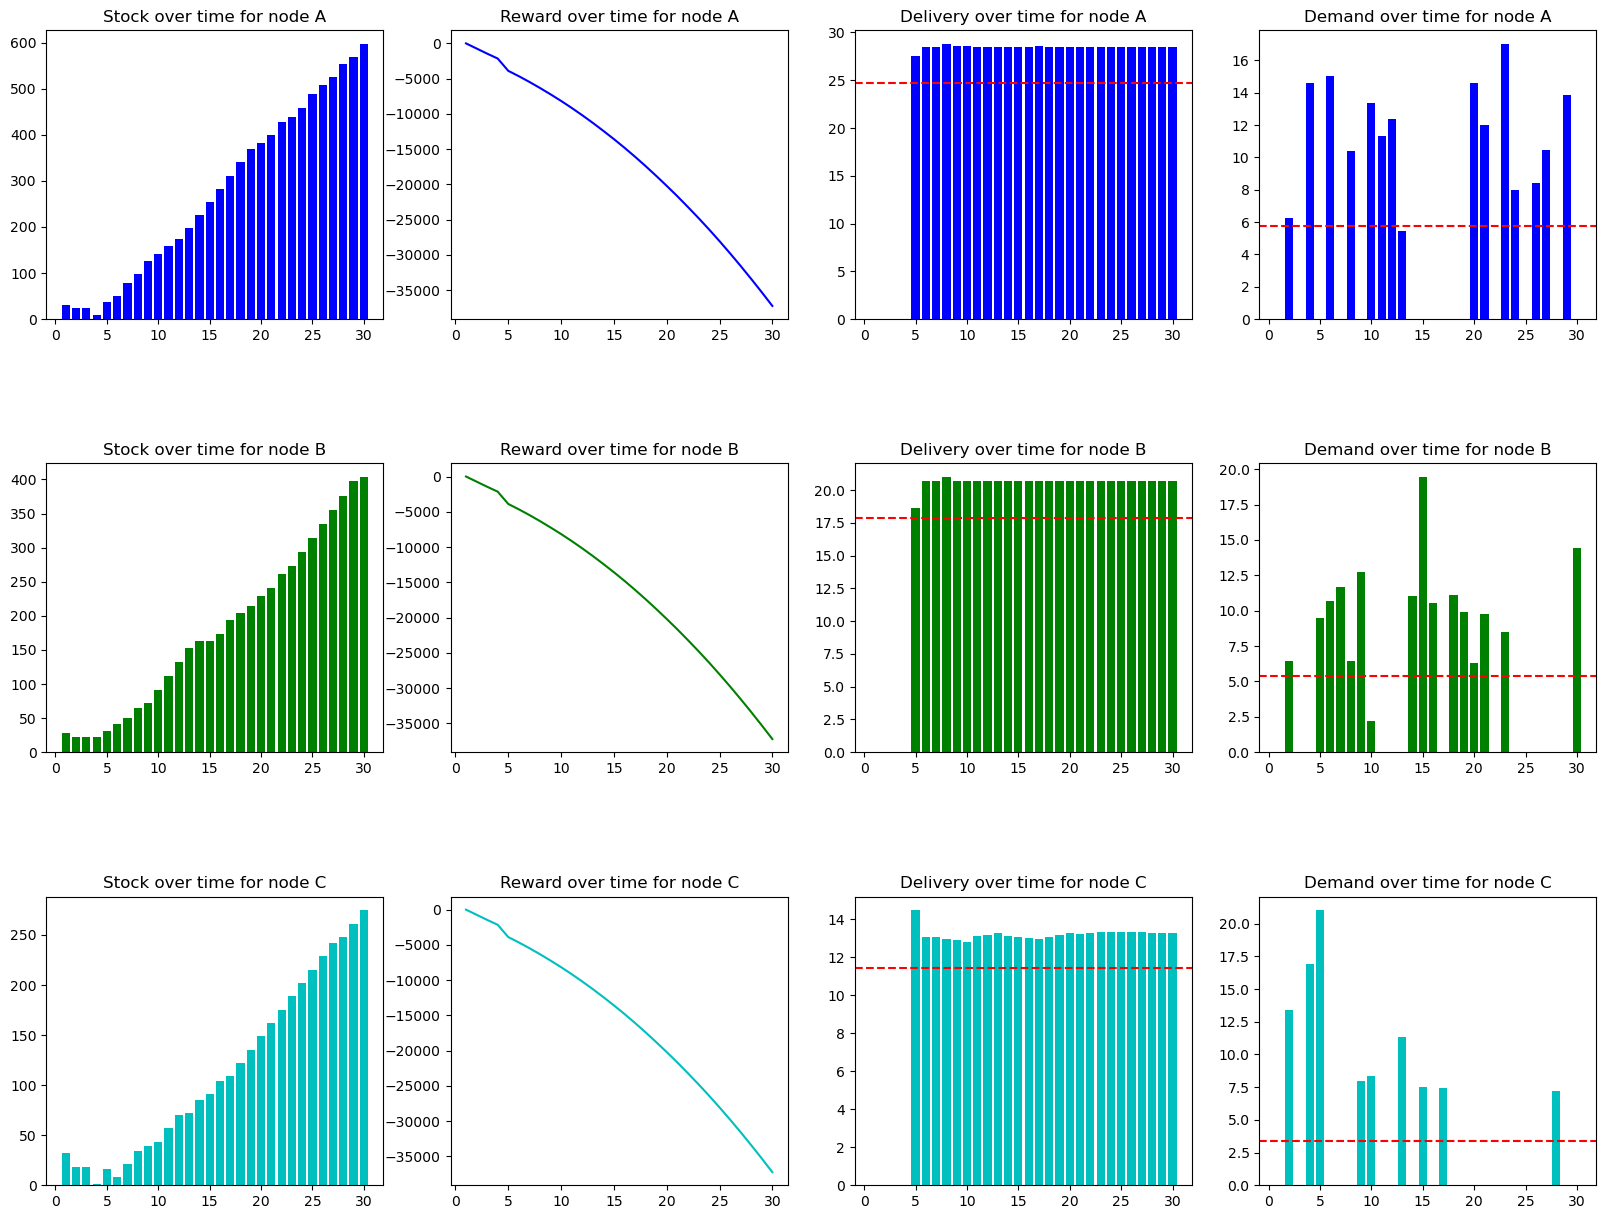

In [12]:
plot_data(df)